In [1]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# State Manual Update 

- LangGraph은 중간 단계의 State를 수동으로 업데이트 할 수 있는 방안을 제공함 
- 이를 통해 에이전트 행동을 수정하여 경로를 제어할 수 있음 
- 또한 에이전트의 실수를 수정하거나, 대체 경로를 탐색하는 것처럼 특정 목표에 따라 에이전트의 동작을 변경할 때 유용함 

## Agent 설계

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph

In [4]:
########## 1. State ##########
class State(TypedDict):
    messages: Annotated[list, add_messages]


########## 2. TOOLS ##########
# 도구 초기화
tool = TavilySearch(max_results=3)

# 도구 목록 정의
tools = [tool]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# LLM + 도구 
llm_with_tools = llm.bind_tools(tools)


########## 3. NODE ##########
# 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Conditional Edge
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)


########## 4. EDGE ##########
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


########## 5. MEMORY ##########
memory = MemorySaver()


########## 6. COMPILE  ##########
graph = graph_builder.compile(checkpointer=memory)


########## 7. VISUALIZE ##########
visualize_graph(graph)

[ERROR] Visualize Graph Error: Failed to render the graph using the Mermaid.INK API. Status code: 204.


In [5]:
print(graph.get_graph().draw_ascii())

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +---------+         
          | chatbot |         
          +---------+         
          .         .         
        ..           ..       
       .               .      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


In [6]:
from langchain_core.runnables import RunnableConfig

In [7]:
question = "LangGraph 가 무엇인지 조사하여 알려주세요!"

# 초기 입력 상태를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    configurable={"thread_id": "001"},  
)

**channels**

- LangGraph 내부에서 노드 간 데이터가 흐르는 경로(통로) 
- 각 노드의 입력과 출력을 연결하는 데이터 이동 경로 

In [8]:
# 그래프 채널 목록 출력
list(graph.channels)

['messages',
 '__start__',
 'chatbot',
 'tools',
 'branch:__start__:__self__:chatbot',
 'branch:__start__:__self__:tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:tools']

## 중단된 지점 찾기 (interrupt 상태 확인)

In [9]:
# 그래프 스트림 호출
# 중단 지점(interrupt_before=[“tools”])에서 중간 상태 확인
events = graph.stream(
    input=input, 
    config=config, 
    interrupt_before=["tools"], 
    stream_mode="values"
)

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_8t5QwQsD43oJC5H1rR9ztiuj)
 Call ID: call_8t5QwQsD43oJC5H1rR9ztiuj
  Args:
    query: LangGraph


In [10]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 가장 최근 메시지 추출
last_message = snapshot.values["messages"][-1]

# 메시지 출력
last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_8t5QwQsD43oJC5H1rR9ztiuj)
 Call ID: call_8t5QwQsD43oJC5H1rR9ztiuj
  Args:
    query: LangGraph


## 도구 결과 수동 수정하기

- `TavilySearch` 도구에서 검색 결과 수정하여 새로운 ToolMessage 생성
- tool_call_id를 기존 메시지에서 추출 후 동일 ID로 새 메시지 생성
- 그래프 상태 업데이트 (graph.update_state)로 반영
- 이후 흐름 계속 실행

In [11]:
modified_search_result = """[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요."""

print(modified_search_result)

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


In [12]:
# 수정하고자 하는 `ToolMessage` 의 `tool_call_id` 추출
tool_call_id = last_message.tool_calls[0]["id"]
print(tool_call_id)

call_8t5QwQsD43oJC5H1rR9ztiuj


**메시지 타입**

- HumanMessage : 사용자 입력 전달 
- AIMessage : LLM의 텍스트 응답 메시지, 일반적인 대화 응답 
- SystemMessage : 대화 설정 또는 시스템 프롬프트 
- ToolMessage : 도구 실행 결과 메시지

In [13]:
from langchain_core.messages import AIMessage, ToolMessage

In [14]:
new_messages = [
    # LLM API의 도구 호출과 일치하는 ToolMessage 필요
    ToolMessage(
        content=modified_search_result,
        tool_call_id=tool_call_id,
    ),
    # LLM의 응답에 직접적으로 내용 추가
    # AIMessage(content=modified_search_result),
]

new_messages[-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.


## 수정된 상태 반영하기 (update_state)

**StateGraph의 `update_state`**

- `update_state` : 주어진 값으로 그래프의 상태를 업데이트
- 마치 `as_node`에서 값이 온 것처럼 동작함

**매개변수**

- `config` (RunnableConfig): 실행 구성
- `values` (Optional[Union[dict[str, Any], Any]]): 업데이트할 값들
- `as_node` (Optional[str]): 값의 출처로 간주할 노드 이름. 기본값은 None

**반환값**

- RunnableConfig

**주요 기능**

1. 체크포인터를 통해 이전 상태를 로드하고 새로운 상태를 저장
2. 서브그래프에 대한 상태 업데이트를 처리
3. `as_node`가 지정되지 않은 경우, 마지막으로 상태를 업데이트한 노드를 찾음
4. 지정된 노드의 writer들을 실행하여 상태를 업데이트
5. 업데이트된 상태를 체크포인트에 저장

**주요 로직**

1. 체크포인터를 확인하고, 없으면 ValueError를 발생시킴
2. 서브그래프에 대한 업데이트인 경우, 해당 서브그래프의 `update_state` 메서드를 호출
3. 이전 체크포인트를 로드하고, 필요한 경우 `as_node`를 결정
4. 지정된 노드의 writer들을 사용하여 상태를 업데이트
5. 업데이트된 상태를 새로운 체크포인트로 저장

**참고**

- 이 메서드는 그래프의 상태를 수동으로 업데이트할 때 사용
- 체크포인터를 사용하여 상태의 버전 관리와 지속성 보장
- `as_node`를 지정하지 않으면 자동으로 결정되지만, 모호한 경우 오류가 발생할 수 있음
- 상태 업데이트 중 SharedValues에 쓰기 작업은 허용되지 않음

In [15]:
graph.update_state(
    # 업데이트할 상태 지정
    config,
    # 제공할 업데이트된 값. `State`의 메시지는 "추가 전용"으로 기존 상태에 추가됨
    {"messages": new_messages},
    as_node="tools",
)

print("(최근 1개의 메시지 출력)\n")
print(graph.get_state(config).values["messages"][-1])

(최근 1개의 메시지 출력)

content='[수정된 웹 검색 결과] \nLangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.\nLangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.\n\n자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과\n[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.' id='dc67905c-7177-4a22-9747-50dc9ae9409e' tool_call_id='call_8t5QwQsD43oJC5H1rR9ztiuj'


In [16]:
snapshot = graph.get_state(config)
snapshot.next

('chatbot',)

In [17]:
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LangGraph는 상태 기반의 다중 액터 애플리케이션을 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. 이 라이브러리는 LLM(대형 언어 모델)을 활용하여 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능 등을 제공합니다.

더 자세한 정보와 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)과 [랭체인 한국어 튜토리얼](https://wikidocs.net/233785)에서 확인할 수 있습니다.


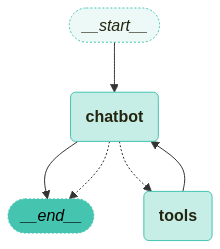

In [18]:
visualize_graph(graph)

In [18]:
print(graph.get_graph().draw_ascii())

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +---------+         
          | chatbot |         
          +---------+         
          .         .         
        ..           ..       
       .               .      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


In [19]:
snapshot = graph.get_state(config)

# 최근 세 개의 메시지 출력
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

LangGraph 가 무엇인지 조사하여 알려주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_8t5QwQsD43oJC5H1rR9ztiuj)
 Call ID: call_8t5QwQsD43oJC5H1rR9ztiuj
  Args:
    query: LangGraph
================================= Tool Message =================================

[수정된 웹 검색 결과] 
LangGraph는 상태 기반의 다중 액터 애플리케이션을 LLM을 활용해 구축할 수 있도록 지원합니다.
LangGraph는 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능을 제공하는 오픈 소스 라이브러리입니다.

자세한 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/) 과
[랭체인 한국어 튜토리얼](https://wikidocs.net/233785) 을 참고하세요.
================================== Ai Message ==================================

LangGraph는 상태 기반의 다중 액터 애플리케이션을 구축할 수 있도록 지원하는 오픈 소스 라이브러리입니다. 이 라이브러리는 LLM(대형 언어 모델)을 활용하여 사이클 흐름, 제어 가능성, 지속성, 클라우드 배포 기능 등을 제공합니다.

더 자세한 정보와 튜토리얼은 [LangGraph 튜토리얼](https://langchain-ai.github.io/langgraph/tutorials/)과 [랭체인 한국어 튜토리얼](

In [20]:
# 다음 상태 출력
print(snapshot.next)

()


## 대화 메시지 직접 수정하기

- `TavilySearch` 도구에서 검색 쿼리 수정
- `thread_id` : 랜덤한 해시값을 생성하는 `generate_random_hash` 함수를 사용하여 적용 

In [21]:
from langchain_teddynote.graphs import generate_random_hash

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

thread_id: 74a3a6


In [22]:
question = "LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!"

input = State(messages=[("user", question)])

config = {"configurable": {"thread_id": thread_id}}

events = graph.stream(
    input=input,
    config=config,
    interrupt_before=["tools"],
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_cSCwDBfSVuCvWBVkDBdeclfB)
 Call ID: call_cSCwDBfSVuCvWBVkDBdeclfB
  Args:
    query: LangGraph


In [23]:
# config 를 복사
config_copy = config.copy()

In [24]:
from langchain_core.messages import AIMessage

# 스냅샷 상태 
snapshot = graph.get_state(config)

# messages 의 마지막 메시지 
existing_message = snapshot.values["messages"][-1]

# 메시지 ID 출력
print("Message ID", existing_message.id)

Message ID run-f5740685-6ec3-4fe6-b3b1-69d4addc253f-0


In [25]:
# 첫 번째 도구 호출 출력
print(existing_message.tool_calls[0])

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph'}, 'id': 'call_cSCwDBfSVuCvWBVkDBdeclfB', 'type': 'tool_call'}


In [26]:
# tool_calls 를 복사하여 새로운 도구 호출 생성
new_tool_call = existing_message.tool_calls[0].copy()

# 쿼리 매개변수 업데이트
new_tool_call["args"] = {"query": "LangGraph Studio"}
new_tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph Studio'},
 'id': 'call_cSCwDBfSVuCvWBVkDBdeclfB',
 'type': 'tool_call'}

기존 메시지를 수정하고 싶은데...

- LangGraph의 메시지 기록은 append-only만 허용 
- 기존 메시지와 동일한 ID로 새 메시지를 만들고, 그걸 덯어쓰기 해야 함 

id=existing_message.id

- 기존 메시지와 같은 ID를 사용하여 새로운 메시지를 만들어서 
- 시스템은 새 메시지가 기존 메시지를 대체(replace) 했다고 인식시킴 -> LangChain message overwrite trick

In [27]:
# AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    id=existing_message.id,  # ID는 메시지를 상태에 추가하는 대신 교체하는 방법으로 처리 (별5개)
)

print(new_message.id)

run-f5740685-6ec3-4fe6-b3b1-69d4addc253f-0


In [28]:
# 수정한 메시지 출력
new_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_cSCwDBfSVuCvWBVkDBdeclfB)
 Call ID: call_cSCwDBfSVuCvWBVkDBdeclfB
  Args:
    query: LangGraph Studio


In [29]:
# 업데이트된 도구 호출 출력
print(new_message.tool_calls[0])

# 메시지 ID 출력
print("\nMessage ID", new_message.id)

# 상태 업데이트
graph.update_state(config, {"messages": [new_message]})

{'name': 'tavily_web_search', 'args': {'query': 'LangGraph Studio'}, 'id': 'call_cSCwDBfSVuCvWBVkDBdeclfB', 'type': 'tool_call'}

Message ID run-f5740685-6ec3-4fe6-b3b1-69d4addc253f-0


{'configurable': {'thread_id': '74a3a6',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09dc0f-4625-6076-8002-89d485ed113e'}}

In [30]:
# 마지막 메시지의 도구 호출 가져오기
graph.get_state(config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': 'LangGraph Studio'},
  'id': 'call_cSCwDBfSVuCvWBVkDBdeclfB',
  'type': 'tool_call'}]

In [31]:
# 그래프 스트림에서 이벤트 수신
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_cSCwDBfSVuCvWBVkDBdeclfB)
 Call ID: call_cSCwDBfSVuCvWBVkDBdeclfB
  Args:
    query: LangGraph Studio
================================= Tool Message =================================
Name: tavily_web_search

[{"url": "https://www.analyticsvidhya.com/blog/2025/06/langgraph-studio/", "title": "LangGraph Studio: A Visual Guide to Building AI Agents", "content": "LangGraph Studio is a specialised integrated development environment (IDE) that helps you build, visualise, and debug complex agentic AI applications using the LangGraph framework. LangGraph Studio is a tool that helps you build AI agents more easily. Generative AI| DeepSeek| OpenAI Agent SDK| LLM Applications using Prompt Engineering| DeepSeek from Scratch| Stability.AI| SSM & MAMBA| RAG Systems using LlamaIndex| Building LLMs for Code| Python| Microsoft Excel| Machine Learning| Deep Learning| Mastering Multimoda

In [32]:
# 이벤트 스트림 생성
events = graph.stream(
    {
        "messages": (
            "user",
            "내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 답변해 주세요. 출처를 반드시 포함해 주세요.",
        )
    },
    config,
    stream_mode="values",
)

# 메시지 이벤트 처리
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

내가 지금까지 배운 내용에 대해서 매우 친절하고 정성스럽게 답변해 주세요. 출처를 반드시 포함해 주세요.
================================== Ai Message ==================================

물론입니다! LangGraph와 LangGraph Studio에 대해 배운 내용을 정리해 드리겠습니다.

### LangGraph
LangGraph는 AI 에이전트 애플리케이션을 구축하기 위한 강력한 프레임워크입니다. 이 프레임워크는 그래프 구조를 활용하여 복잡한 추론 프로세스와 다단계 의사 결정을 효율적으로 설계하고 구현할 수 있도록 돕습니다. 개발자는 유연하고 재사용 가능한 구성 요소를 만들고 상태 관리를 간소화할 수 있습니다.

### LangGraph Studio
LangGraph Studio는 LangGraph로 구축된 애플리케이션을 시각화하고 디버깅할 수 있는 통합 개발 환경(IDE)입니다. 이 도구는 애플리케이션 구조를 직관적으로 이해하고 각 처리 단계를 자세히 검사할 수 있는 기능을 제공합니다. 또한, 실행 중 상태를 편집하고 다양한 시나리오를 테스트할 수 있는 기능을 통해 개발 프로세스를 간소화합니다.

#### 주요 기능
1. **그래프 시각화**: LangGraph로 생성된 애플리케이션의 구조를 시각적으로 표시하여 노드와 엣지 간의 관계를 직관적으로 이해할 수 있습니다.
2. **인터랙티브 실행**: 그래프의 각 노드를 개별적으로 실행하고, 다양한 입력과 설정으로 그래프를 실행하여 실시간으로 실행 결과를 확인할 수 있습니다.
3. **스레드 관리**: 여러 실행 스레드를 생성하고 관리할 수 있으며, 스레드 간 전환 및 비교가 가능합니다.
4. **상태 편집**: 실행 중인 스레드의 상태를 동적으로 편집하고, 편집된 상태에서 새로운 스레드를 포크할 수

In [33]:
# 최종 응답 
# 최종 상태에서 `messages` 의 마지막 메시지로 확인 
graph.get_state(config).values["messages"][-1].pretty_print()

================================== Ai Message ==================================

물론입니다! LangGraph와 LangGraph Studio에 대해 배운 내용을 정리해 드리겠습니다.

### LangGraph
LangGraph는 AI 에이전트 애플리케이션을 구축하기 위한 강력한 프레임워크입니다. 이 프레임워크는 그래프 구조를 활용하여 복잡한 추론 프로세스와 다단계 의사 결정을 효율적으로 설계하고 구현할 수 있도록 돕습니다. 개발자는 유연하고 재사용 가능한 구성 요소를 만들고 상태 관리를 간소화할 수 있습니다.

### LangGraph Studio
LangGraph Studio는 LangGraph로 구축된 애플리케이션을 시각화하고 디버깅할 수 있는 통합 개발 환경(IDE)입니다. 이 도구는 애플리케이션 구조를 직관적으로 이해하고 각 처리 단계를 자세히 검사할 수 있는 기능을 제공합니다. 또한, 실행 중 상태를 편집하고 다양한 시나리오를 테스트할 수 있는 기능을 통해 개발 프로세스를 간소화합니다.

#### 주요 기능
1. **그래프 시각화**: LangGraph로 생성된 애플리케이션의 구조를 시각적으로 표시하여 노드와 엣지 간의 관계를 직관적으로 이해할 수 있습니다.
2. **인터랙티브 실행**: 그래프의 각 노드를 개별적으로 실행하고, 다양한 입력과 설정으로 그래프를 실행하여 실시간으로 실행 결과를 확인할 수 있습니다.
3. **스레드 관리**: 여러 실행 스레드를 생성하고 관리할 수 있으며, 스레드 간 전환 및 비교가 가능합니다.
4. **상태 편집**: 실행 중인 스레드의 상태를 동적으로 편집하고, 편집된 상태에서 새로운 스레드를 포크할 수 있습니다.
5. **인간 개입 지원**: 특정 지점에서 수동 입력이나 의사 결정을 요구하는 워크플로우를 지원합니다.
6. **LangSmith 통합**: 팀 협업을 촉진하기 위해 LangSmith를 통해 로그인 및 인증을 지원합니다.

이러한 기능들은

## 저장된 상태에서 재실행하기 (Replay)

- 지난 스냅샷을 확인 후 특정 노드로 되돌아가, State를 수정한 뒤 해당 노드부터 다시 진행

In [34]:
to_replay_state = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):

    messages = state.values["messages"]

    if len(messages) > 0:
        print(state.values["messages"][-1].id)
        # 메시지 수 및 다음 상태 출력
        print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
        print("-" * 80)
        # 특정 상태 선택 기준: 채팅 메시지 수
        if len(state.values["messages"]) == 2:
            # 특정 메시지 ID 선택
            to_replay_state = state

run-e63fa7d0-53b9-4892-b37d-1ea05d24528c-0
메시지 수:  6 다음 노드:  ()
--------------------------------------------------------------------------------
bf751591-ee2b-4024-8cd3-3880e25d5eab
메시지 수:  5 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-844f5dfd-77a7-428c-b497-43dd257b1bdd-0
메시지 수:  4 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------
run-844f5dfd-77a7-428c-b497-43dd257b1bdd-0
메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
c1450465-b878-4e00-a20c-31522c8f0f2c
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
run-f5740685-6ec3-4fe6-b3b1-69d4addc253f-0
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
run-f5740685-6ec3-4fe6-b3b1-69d4addc253f-0
메시지 수:  2 다음 노드:  ('tools',)
------------------------------

In [35]:
from langchain_teddynote.messages import display_message_tree

# 선택한 메시지 가져오기
existing_message = to_replay_state.values["messages"][-1]

# 메시지 트리 출력
display_message_tree(existing_message)

    content: ""
    additional_kwargs:
        tool_calls:
            index [0]
                id: "call_cSCwDBfSVuCvWBVkDBdeclfB"
                function: {"arguments": "{"query":"LangGraph"}", "name": "tavily_web_search"}
                type: "function"
        refusal: None
    response_metadata:
        token_usage:
            completion_tokens: 18
            prompt_tokens: 110
            total_tokens: 128
            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}
            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
        model_name: "gpt-4o-mini-2024-07-18"
        system_fingerprint: "fp_560af6e559"
        finish_reason: "tool_calls"
        logprobs: None
    type: "ai"
    name: None
    id: "run-f5740685-6ec3-4fe6-b3b1-69d4addc253f-0"
    example: False
    tool_calls:
        index [0]
            name: "tavily_web_search"
            args: {"query": "LangG

In [36]:
# 검색 쿼리 업데이트 
tool_call = existing_message.tool_calls[0].copy()
tool_call["args"] = {"query": "LangGraph human-in-the-loop workflow site:reddit.com"}
tool_call

{'name': 'tavily_web_search',
 'args': {'query': 'LangGraph human-in-the-loop workflow site:reddit.com'},
 'id': 'call_cSCwDBfSVuCvWBVkDBdeclfB',
 'type': 'tool_call'}

In [37]:
# 업데이트된 AIMessage 생성
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[tool_call],
    id=existing_message.id,
)

# 수정한 메시지 출력
new_message.tool_calls[0]["args"]

{'query': 'LangGraph human-in-the-loop workflow site:reddit.com'}

In [38]:
# 업데이트 전 메시지 확인
graph.get_state(to_replay_state.config).values["messages"][-1].tool_calls

[{'name': 'tavily_web_search',
  'args': {'query': 'LangGraph'},
  'id': 'call_cSCwDBfSVuCvWBVkDBdeclfB',
  'type': 'tool_call'}]

In [39]:
# 상태 업데이트
updated_state = graph.update_state(
    to_replay_state.config,
    {"messages": [new_message]},
)
updated_state

{'configurable': {'thread_id': '74a3a6',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09dc11-1d38-69fe-8002-86edf2ad82b0'}}

In [40]:
# config에 updated_state 전달
for event in graph.stream(None, updated_state, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_cSCwDBfSVuCvWBVkDBdeclfB)
 Call ID: call_cSCwDBfSVuCvWBVkDBdeclfB
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_web_search

[{"url": "https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/", "title": "LangGraph's human-in-the-loop - Overview", "content": "* Key capabilities * Patterns hil human-in-the-loop overview   # Human-in-the-loop¶ ## Key capabilities¶ This supports asynchronous human review or input without time constraints. * **Flexible integration points**: Human-in-the-loop logic can be introduced at any point in the workflow. This allows targeted human involvement, such as approving API calls, correcting outputs, or guiding conversations. This pattern often involves routing the graph based on the human's input. * Edit graph st

In [41]:
# 최종 결과 출력
for msg in graph.get_state(config).values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

LangGraph 에 대해서 배워보고 싶습니다. 유용한 자료를 추천해 주세요!
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_cSCwDBfSVuCvWBVkDBdeclfB)
 Call ID: call_cSCwDBfSVuCvWBVkDBdeclfB
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_web_search

[{"url": "https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/", "title": "LangGraph's human-in-the-loop - Overview", "content": "* Key capabilities * Patterns hil human-in-the-loop overview   # Human-in-the-loop¶ ## Key capabilities¶ This supports asynchronous human review or input without time constraints. * **Flexible integration points**: Human-in-the-loop logic can be introduced at any point in the workflow. This allows targeted human involvement, such as approving API calls, correctin

-----
** End of Documents **